In [1]:
%pylab inline

import numpy as np
# import pylab as plt
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import os
import warnings
warnings.filterwarnings("ignore")
from collections import namedtuple
import rnaseqTools

sns.set_style('ticks')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
## --------------------Preparing for mapping--------------------------
# load mito genes and sex genes, then excluded them from the gene list.
df_sexGenes = pd.read_csv('../10X/data_h5/sex_genes.csv')
df_mitoGenes = pd.read_csv('../10X/data_h5/mito_genes.csv')
sexGenes = np.array(df_sexGenes)
mitoGenes = np.array(df_mitoGenes)
excGenes_tem = np.r_[sexGenes,mitoGenes]

excGenes=list()
for i in range(len(excGenes_tem)):
        excGenes.append(excGenes_tem[i][0])        
print('Number of exckuded genes:',len(excGenes))

# create the color table for neuron clusters.
clusterColors_table=np.array(['#98A14E', 
                              '#008000', '#2E8B57', '#96C390', '#6FBC1E', '#6D9269', 
                              '#90EE90', '#224700', '#228B22', '#00FF7F', '#ADD8E6',  #'#7CFC00',#  10
                              '#4666A6', '#1E90FF', '#B4BA77', '#1B655D', '#008B8B', 
                              '#00CED1', '#20B2AA', '#66CDAA', '#00FF00',     ### greenish colors for excitatory neurons 
                              
                              '#DDACC9', '#DEB887', '#DD8091', '#7C086C', '#FFD700', 
                              '#FF8C97', '#FFA388', '#C77963', '#7E0ACB', '#FF4500',
                              '#FF0000', '#9900B3', '#C9AE9C', '#AA4DB5', '#FF1493',
                              '#AB1DFF', '#FF5FCD', '#FFC0CB', '#B09FFF', '#DAA520', 
                              '#992E81', '#F70CF3', '#FFBF09', '#AB379C', '#F5DEB3', 
                              '#7779BF', '#626EB8', '#FFFF00', '#FF8011', '#FF9F2C',
                              '#FF88AD', '#C22B74', '#FFB22B',      ### redish colors for inhibttory neurons.
                              ])

Number of exckuded genes: 3615


In [3]:
# define data format
from collections import namedtuple
RNAseqData = namedtuple('RNAseqData', 'counts genes cells clusterIDs clusterLabels clustergroupIDs '
                                      'clusterColors clusterNames clustergroupNames cellnames mappingrates')

# Load the patchSeq data from csv file.

In [4]:
patch_data = pd.read_excel('./data/Ins_patchSeq_new.xlsx')

In [5]:
patch_data

,gene_order,cellName,s173,s174,s175,s177,s209,s210,s211,s212,...,n87,n88,n89,n8,n90,n91,n92,n94,n96,n9
0,"""""",cellType,VEN,VEN,PC,NaN,INTER,PC,VEN,PC,...,NaN,INTER,INTER,NaN,VEN,INTER,NaN,INTER,INTER,NaN
1,"""""",cellSubtype,VEN_Long,VEN_Long,PC_L5,NaN,INTER_L5,PC_L6,VEN_Long,PC_L5,...,NaN,INTER_L5,INTER_L5,NaN,VEN_Short,L23_INTER,NaN,L23_INTER,L23_INTER,NaN
2,"""""",MappingRate,0.8957,0.7971,0.8867,0.8785,0.8207,0.7865,0.8871,0.8337,...,0.8258,0.865,0.7652,0.76,0.8734,0.8053,0.8213,0.8197,0.751,0.2173
3,"""""",batch,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,...,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5
4,"""""",# of Total Reads,2286636.72,7547298.05,4096627.48,9263391.89,4834936.14,6305879.98,4812780.15,5636087.57,...,2101502.04,1740485.41,3306850.15,1721003.1,569116.48,3291647.51,2750171.7,4211850.26,1653226.49,1322817.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16460,16456,ZXDC,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16461,16457,ZYG11A,0,0,0,0,18,0,0,50,...,0,0,3,0,0,0,30,0,0,0
16462,16458,ZYG11B,1,15,36,213,160,259,328,124,...,92,522,283,33,3,0,441,105,6,0
16463,16459,ZYX,1,275,131,2163,615,35,164,337,...,0,0,634,0,0,76,126,136,0,230


In [6]:
patch_data.index = patch_data['cellName'].values
patch_data = patch_data.drop(['gene_order','cellName'],axis=1)
patch_data

,s173,s174,s175,s177,s209,s210,s211,s212,s213,s214,...,n87,n88,n89,n8,n90,n91,n92,n94,n96,n9
cellType,VEN,VEN,PC,NaN,INTER,PC,VEN,PC,NaN,NaN,...,NaN,INTER,INTER,NaN,VEN,INTER,NaN,INTER,INTER,NaN
cellSubtype,VEN_Long,VEN_Long,PC_L5,NaN,INTER_L5,PC_L6,VEN_Long,PC_L5,NaN,NaN,...,NaN,INTER_L5,INTER_L5,NaN,VEN_Short,L23_INTER,NaN,L23_INTER,L23_INTER,NaN
MappingRate,0.8957,0.7971,0.8867,0.8785,0.8207,0.7865,0.8871,0.8337,0.8561,0.7926,...,0.8258,0.865,0.7652,0.76,0.8734,0.8053,0.8213,0.8197,0.751,0.2173
batch,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,...,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5
# of Total Reads,2286636.72,7547298.05,4096627.48,9263391.89,4834936.14,6305879.98,4812780.15,5636087.57,4163858.02,5282259.28,...,2101502.04,1740485.41,3306850.15,1721003.1,569116.48,3291647.51,2750171.7,4211850.26,1653226.49,1322817.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0,0,4,0,0,0,0,0,13,0,...,0,0,0,0,0,0,0,0,0,0
ZYG11A,0,0,0,0,18,0,0,50,4,0,...,0,0,3,0,0,0,30,0,0,0
ZYG11B,1,15,36,213,160,259,328,124,93,26,...,92,522,283,33,3,0,441,105,6,0
ZYX,1,275,131,2163,615,35,164,337,14,701,...,0,0,634,0,0,76,126,136,0,230


In [7]:
# patch_data = patch_data.drop('gene_order',axis=1)
# genes_patch = patch_data.values[5:,0].astype(str)
genes_patch = patch_data.index[5:]
# exclude the cells with mapping rates < 0.4
patch_data=patch_data.iloc[:,0:].loc[:,patch_data.iloc[2,0:] >= 0.4]

counts_patch = patch_data.values[5:,:].astype('float').T
cells_patch = patch_data.columns
cell_type = patch_data.values[0,:]
cell_subType = patch_data.values[1,:]
mapRate_str = patch_data.values[2,:]
mappingrates=mapRate_str
numTotalReads = patch_data.values[3,:]

In [8]:
patch_data

,s173,s174,s175,s177,s209,s210,s211,s212,s213,s214,...,n86,n87,n88,n89,n8,n90,n91,n92,n94,n96
cellType,VEN,VEN,PC,NaN,INTER,PC,VEN,PC,NaN,NaN,...,PC,NaN,INTER,INTER,NaN,VEN,INTER,NaN,INTER,INTER
cellSubtype,VEN_Long,VEN_Long,PC_L5,NaN,INTER_L5,PC_L6,VEN_Long,PC_L5,NaN,NaN,...,PC_L23,NaN,INTER_L5,INTER_L5,NaN,VEN_Short,L23_INTER,NaN,L23_INTER,L23_INTER
MappingRate,0.8957,0.7971,0.8867,0.8785,0.8207,0.7865,0.8871,0.8337,0.8561,0.7926,...,0.8764,0.8258,0.865,0.7652,0.76,0.8734,0.8053,0.8213,0.8197,0.751
batch,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,batch-1,...,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5,batch-5
# of Total Reads,2286636.72,7547298.05,4096627.48,9263391.89,4834936.14,6305879.98,4812780.15,5636087.57,4163858.02,5282259.28,...,1105635.21,2101502.04,1740485.41,3306850.15,1721003.1,569116.48,3291647.51,2750171.7,4211850.26,1653226.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0,0,4,0,0,0,0,0,13,0,...,0,0,0,0,0,0,0,0,0,0
ZYG11A,0,0,0,0,18,0,0,50,4,0,...,0,0,0,3,0,0,0,30,0,0
ZYG11B,1,15,36,213,160,259,328,124,93,26,...,0,92,522,283,33,3,0,441,105,6
ZYX,1,275,131,2163,615,35,164,337,14,701,...,0,0,0,634,0,0,76,126,136,0


In [9]:
# resort the cell properties for loading into a pickle file.
patchCell_groups=np.ones(cell_type.size)
for i in range(cell_type.size):
    if cell_type[i] == 'PC':
        patchCell_groups[i]=1
    elif ((cell_type[i] == 'VEN') | (cell_type[i] == 'Long') | (cell_type[i] == 'Short') ):
        patchCell_groups[i]=2
    elif ((cell_type[i] == 'Inter') | (cell_type[i] == 'inter') | (cell_type[i] == 'INTER')):
        patchCell_groups[i]=0
    elif ( np.isnan(cell_type[i]) | (cell_type[i] == 'NAN') | (cell_type[i] == 'Nan') ):
        patchCell_groups[i]=-1 
        
clusterIDs=np.zeros(cells_patch.size)  # the default cell subtype id is 0 (nan, none defiend)
clusterIDs[cell_subType=='INTER_L23']=1
clusterIDs[cell_subType=='L23_INTER']=1
clusterIDs[cell_subType=='INTER_L1']=1
clusterIDs[cell_subType=='INTER_L5']=1
clusterIDs[cell_subType=='INTER_L6']=1
clusterIDs[cell_subType=='PC_L23']=2
clusterIDs[cell_subType=='L23_PC']=2
clusterIDs[cell_subType=='PC_L5']=3
clusterIDs[cell_subType=='PC_L5ET']=4
clusterIDs[cell_subType=='VEN_Long']=5
clusterIDs[cell_subType=='VEN_Short']=6
clusterIDs[cell_subType=='PC_L6']=8
clusterIDs[cell_subType=='L6_PC']=8
    
# clusterColors=np.array(['#DDACC9', '#A700FF', '#FF00B3'])

In [10]:
# save the data into.
patchSeqData = RNAseqData(counts=counts_patch, genes=genes_patch, cells=cells_patch, clusterIDs=clusterIDs, 
                          clusterLabels=None, clustergroupIDs=patchCell_groups, clusterColors = None, 
                          clusterNames = cell_subType, clustergroupNames = None,cellnames=cells_patch,
                          mappingrates=mappingrates)
pickle.dump(patchSeqData, open('./data/processedData/insPatchDataNew0423.pickle', 'wb'))  

# Load the insular patchSeq data (all neurons)-from processed pickle file

In [11]:
# loading patched cell data
# patchSeqData=pickle.load(open('./data/processedData/insPatchDataNew0905.pickle', 'rb')) 
# patchSeqData=pickle.load(open('./data/processedData/insPatchDataNew1116.pickle', 'rb')) 
# patchSeqData=pickle.load(open('./data/processedData/insPatchDataNew0324.pickle', 'rb')) 
# patchSeqData=pickle.load(open('./data/processedData/insPatchDataNew0405.pickle', 'rb')) 
# patchSeqData=pickle.load(open('./data/processedData/insPatchDataNew0416.pickle', 'rb')) 
patchSeqData=pickle.load(open('./data/processedData/insPatchDataNew0423.pickle', 'rb')) 

In [12]:
counts_patchSeq = patchSeqData.counts
genes_patchSeq = patchSeqData.genes.astype('str')
patchCellNames = patchSeqData.cellnames
patchCellTypeIDs = patchSeqData.clustergroupIDs
patchCellTypes = patchSeqData.clustergroupNames
patchCellSubtypeIDs= patchSeqData.clusterIDs
patchCellSubtypes= patchSeqData.clusterNames
mappingRates= patchSeqData.mappingrates

### Initialize the predicted_table

In [13]:
# output the original neuronal types and predicted labels into a dataframe for comparasion in convinient.
# predictClusterLabels = patchCellID
cellType_labels = patchSeqData.clusterIDs

patchCell_groups = patchSeqData.clustergroupIDs
nPatchedCell = patchCell_groups.shape
predictClusterIDs = np.ones(nPatchedCell)*-10
maxCorrs = np.zeros(nPatchedCell)
d={#'patchCellNames': patchCellNames, 
   'patchCellTypeIDs': patchCellTypeIDs,
   'patchCellSubtypeIDs': patchCellSubtypeIDs,
   'patchCellSubtypeNames': patchCellSubtypes,
   'mappingRates': mappingRates,
   'predictClustersIDs':predictClusterIDs,
   'mainClusterCorrs': maxCorrs }

cells_patch = patchSeqData.cells
results = pd.DataFrame(data=d,index=cells_patch)

# Mapping Inhibitory neurons

In [14]:
Inhib_idx = patchCell_groups==0
patchSeqCounts_inhib = patchSeqData.counts[Inhib_idx,:]
patchCellNames_inhib = patchCellNames[Inhib_idx]
patchCellTypeIDs_inhib = patchCellTypeIDs[Inhib_idx]
# patchCellTypes_inhib = patchCellTypes[Inhib_idx]
patchCellSubtypeIDs_inhib = patchCellSubtypeIDs[Inhib_idx]
patchCellSubtypes_inhib = patchCellSubtypes[Inhib_idx]
mappingRates_inhib = mappingRates[Inhib_idx]

In [15]:
ad_Inhib = sc.read('../10X/data_h5/Inhib_sorted.h5ad')
ad_Inhib

AnnData object with n_obs × n_vars = 16364 × 19944
    obs: 'batch', 'doublet_score', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'sampleLayers', 'cluster_labels', 'Sex', 'mainMarker'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Sex_colors', 'batch_colors', 'cluster_labels_colors', 'cluster_names', 'hvg', 'leiden', 'leiden_colors', 'mainMarker_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sampleLayers_colors', 'tsne', 'umap'
    obsm: 'X_harmonypca', 'X_pca', 'X_tsne', 'X_umap', 'X_umapharmony', 'X_umapraw'
    varm: 'PCs'
    layers: 'RawCounts'
    obsp: 'connectivities', 'distances'

In [16]:
# set the excluded genes (sex genes, mito genes) as not HVGs.
ad_Inhib.var['highly_variable'].values[ad_Inhib.var['highly_variable'].index.isin(excGenes)]=False

# extract and reformat data from AnnData (10X data)
counts_10X = ad_Inhib.layers['RawCounts'][:,ad_Inhib.var['highly_variable']]
genes = ad_Inhib.var_names[ad_Inhib.var['highly_variable']]
cells = ad_Inhib.obs_names
clusterIDs = ad_Inhib.obs['leiden'].astype('int')

# extract the neurons positions in the embeded figures
Z0_umap = ad_Inhib.obsm['X_umap']
# assign the colors to neuron types.
clusterColors_inhib = clusterColors_table[ad_Inhib.obs['leiden'].astype('int')+20]

In [17]:
# calculate the HVGs for mapping. 
importantGenesIndex = rnaseqTools.geneSelection(counts_10X, n=500, threshold=1, decay=4, plot=False)
counts_10X = counts_10X[:, importantGenesIndex] 
importantGenes = genes[importantGenesIndex]

Chosen offset: 1.48


### mapping to inhibitory clusters

In [18]:
predictClusters_inhib, Corrs_inhib = rnaseqTools.map_to_clusters(counts_10X, importantGenes,
                patchSeqCounts_inhib, patchSeqData.genes, clusterIDs, bootstrap = True)

Using a common set of 495 genes.
.................................................................................................... done


In [19]:
predictClusters_inhib

array([ 4., 32.,  4., 31., 24.,  4., 30.,  2., 19., 13., 24., 10., 26.,
       10.,  5.,  4.,  2., 24., 27.,  2., 27., 30., 14., 32., 24., 16.,
        2., 21., 16., 13., 11., 21., 19., 29.])

In [20]:
# output the original neuronal types and predicted labels into a dataframe for comparasion in convinient.
# predictClusterLabels = patchCellID
cellType_labels = patchSeqData.clusterIDs

maxCorrs_inhib = np.max(Corrs_inhib,axis=1)
d={#'patchCellNames': patchCellNames, 
   'patchCellTypeIDs': patchCellTypeIDs_inhib,
   # 'patchCellTypeNames': patchCellTypes_inhib,
   'patchCellSubtypeIDs': patchCellSubtypeIDs_inhib,
   'patchCellSubtypeNames': patchCellSubtypes_inhib,
   'mappingRates': mappingRates_inhib,
   'predictClustersIDs':predictClusters_inhib.astype(int),
   'mainClusterCorrs': maxCorrs_inhib }

results_inhib = pd.DataFrame(data=d,index=patchCellNames_inhib)

In [21]:
results_inhib.to_csv("./data/mappingRes/results_inhib.csv", mode="a" ,index = True, header=True)

### mapping to the Atlas of the inhibitory neurons

In [22]:
pos_umap, pos_boot2 = rnaseqTools.map_to_tsne(counts_10X, importantGenes,
                patchSeqCounts_inhib, patchSeqData.genes.astype('str'),
                Z0_umap, bootstrap = True, knn=10,seed=42)

Using a common set of 495 genes.
Bootstrapping.................................................................................................... done


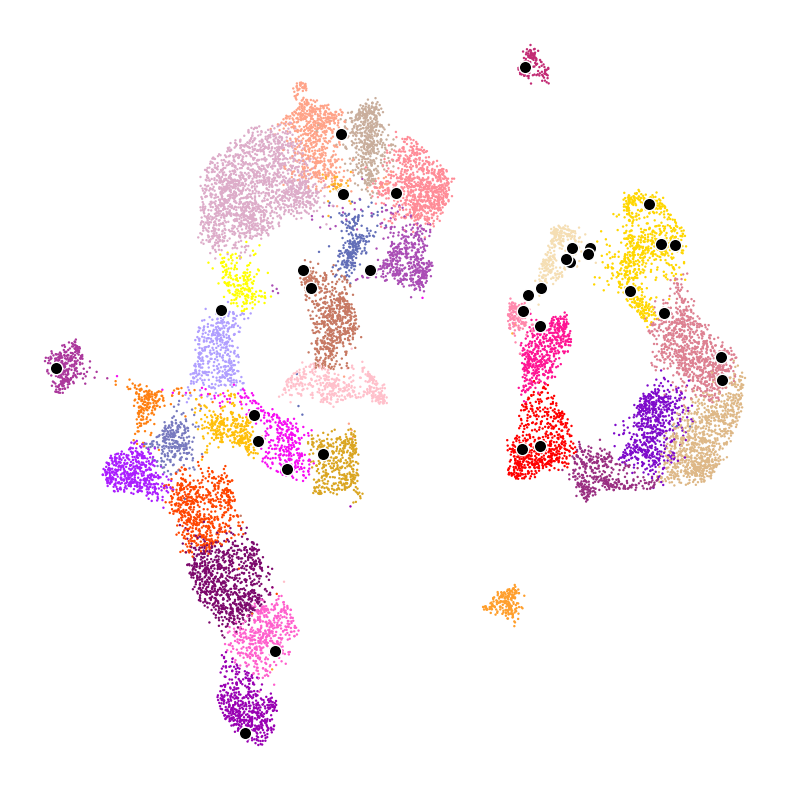

In [23]:
figsize(8,8)
plt.scatter(Z0_umap[:,0], Z0_umap[:,1], s=3, alpha=1,
            c = clusterColors_inhib, edgecolor='none',
            rasterized=True)
# plot patchseq data (predicted inhibitory cells)
plt.scatter(pos_umap[:,0], pos_umap[:,1], s=80, alpha=1,
            c = 'k', edgecolor='w', rasterized=True)
# set figure properties
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

In [24]:
pos_umap = rnaseqTools.map_to_tsne1(counts_10X, importantGenes,
                patchSeqCounts_inhib, patchSeqData.genes.astype('str'), np.array(ad_Inhib.obs['leiden'].astype('int')),  predictClusters_inhib,
                Z0_umap, bootstrap = True, knn=10,seed=42)

Using a common set of 495 genes.
Bootstrapping.................................................................................................... done
(4, 2, 100)
Using a common set of 495 genes.
Bootstrapping.................................................................................................... done
(4, 2, 100)
Using a common set of 495 genes.
Bootstrapping.................................................................................................... done
(1, 2, 100)
Using a common set of 495 genes.
Bootstrapping.................................................................................................... done
(2, 2, 100)
Using a common set of 495 genes.
Bootstrapping.................................................................................................... done
(1, 2, 100)
Using a common set of 495 genes.
Bootstrapping.................................................................................................... done
(2, 2, 100)
Using a common s

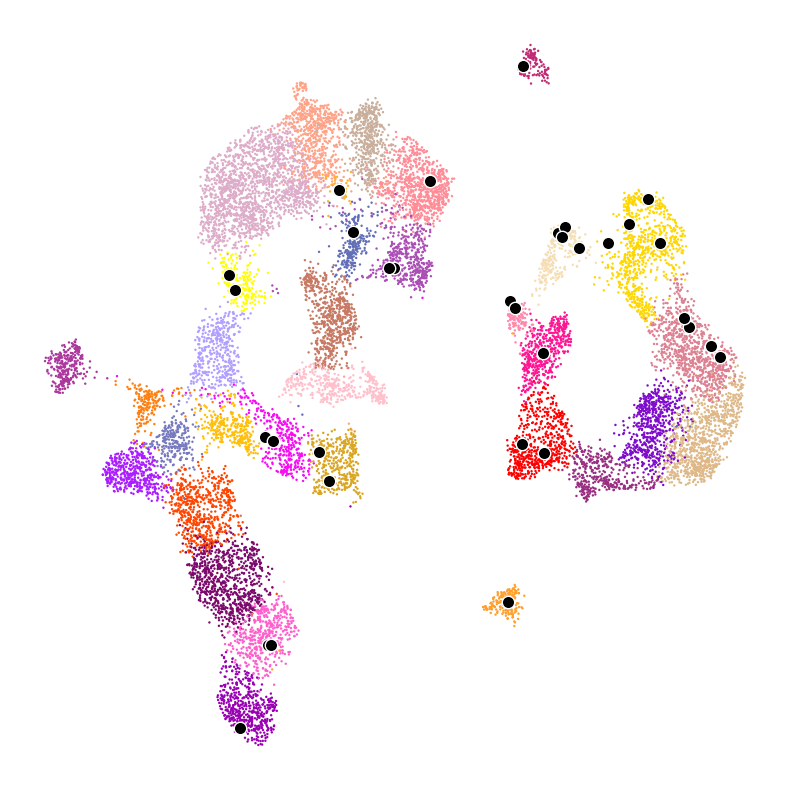

In [26]:
figsize(8,8)
plt.scatter(Z0_umap[:,0], Z0_umap[:,1], s=3, alpha=1,
            c = clusterColors_inhib, edgecolor='none',
            rasterized=True)
# plot patchseq data (predicted inhibitory cells)
plt.scatter(pos_umap[:,0]-0.2*np.random.rand(34), pos_umap[:,1]+0.2*np.random.rand(34), s=80, alpha=1,
            c = 'k', edgecolor='w', rasterized=True)
# set figure properties
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('./figures/patchSeq_2_Inhib_10X-.pdf',dpi=600)

In [27]:
pos_umap_inhib = pd.DataFrame(data=pos_umap,index=patchCellNames_inhib,columns=['UMAP1','UMAP2'])
pos_umap_inhib.insert(2,'predictClusterID',predictClusters_inhib.astype('int'))
pos_umap_inhib.insert(0,'patchCellSubtypeIDs',patchCellSubtypeIDs_inhib.astype('int'))

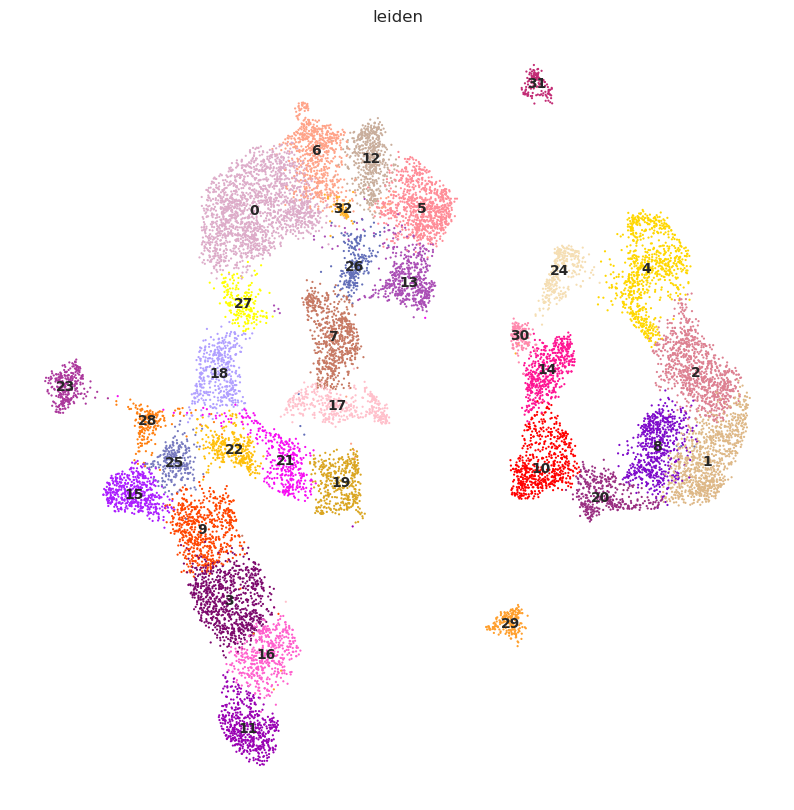

In [29]:
figsize(10,10)
sc.pl.umap(ad_Inhib,color=['leiden'],legend_loc='on data', frameon=False, size=10)#, save='.inhib_10X.pdf')

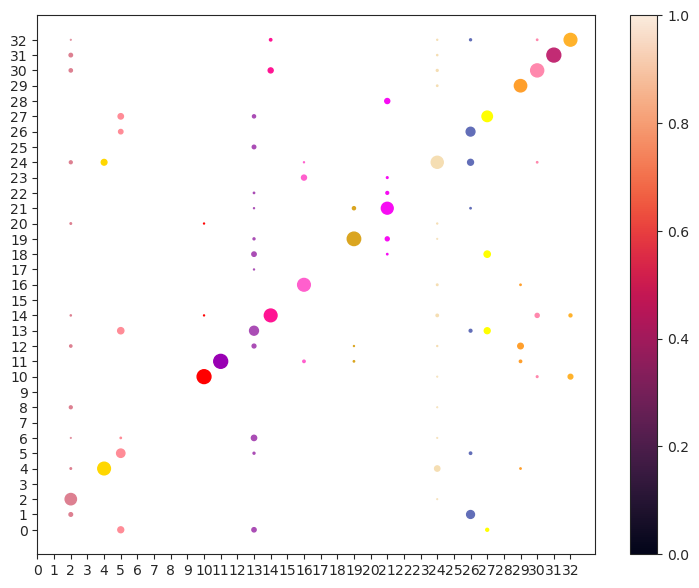

In [30]:
# plot the correlations between clusters, clusters sequenced from 0-32 according to the clusterIDs (leiden ID).
nCell = np.ones(33)*np.nan
meanCorrs = np.ones([33,33])*np.nan
for i in range(33):
    nCell[i] = np.sum(predictClusters_inhib==i)
    meanCorrs[i,:] = np.mean( Corrs_inhib[predictClusters_inhib==i,:],axis=0 )
    
x = np.transpose(range(33)*np.ones([33,33]))
y = np.ones([33,33])*range(33)

figsize(9,7)
plt.scatter(x,y,s=meanCorrs*100,c=clusterColors_table[20:].repeat(33))
plt.xticks(range(33))
plt.yticks(range(33))
colorbar()
# plt.savefig('./figures/Corr_dotPlot_inhibMapiing.pdf',dpi=600)

In [31]:
# Renew the predicted cluster IDs of inhibitory neurons in the results.
results.loc[results.index[results.index.isin(results_inhib.index)],['predictClustersIDs']] = results_inhib['predictClustersIDs']+20

# <font size=8> mapping excitatory neurons

In [32]:
Ext_idx = patchCellTypeIDs!=0
patchSeqCounts_Ext = patchSeqData.counts[Ext_idx,:]
patchCellNames_Ext = patchSeqData.cellnames[Ext_idx]
patchCellTypeIDs_Ext = patchSeqData.clustergroupIDs[Ext_idx]
# patchCellTypes_Ext = patchSeqData.clustergroupNames
patchCellSubtypeIDs_Ext = patchSeqData.clusterIDs[Ext_idx]
patchCellSubtypes_Ext = patchSeqData.clusterNames[Ext_idx]
mappingRates_Ext = patchSeqData.mappingrates[Ext_idx]

In [33]:
ad_Ext = sc.read('../10X/data_h5/Ext_20231019.h5ad')
ad_Ext

AnnData object with n_obs × n_vars = 21733 × 19944
    obs: 'batch', 'doublet_score', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster_labels', 'sampleLayers'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cluster_labels_colors', 'cluster_names', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sampleLayers_colors', 'tsne', 'umap'
    obsm: 'X_harmonypca', 'X_pca', 'X_tsne', 'X_umap', 'X_umapharmony', 'X_umapraw'
    varm: 'PCs'
    layers: 'RawCounts'
    obsp: 'connectivities', 'distances'

In [34]:
# set the excluded genes (sex genes, mito genes) as not HVGs.
ad_Ext.var['highly_variable'].values[ad_Ext.var['highly_variable'].index.isin(excGenes)]=False

# extract and reformat data from AnnData (10X data)
counts_10X = ad_Ext.layers['RawCounts'].X[:,ad_Ext.var['highly_variable']]
genes = ad_Ext.var_names[ad_Ext.var['highly_variable']]
cells = ad_Ext.obs_names
clusterIDs = ad_Ext.obs['leiden'].astype('int')

# extract the neurons positions in the embeded figures
Z0_umap = ad_Ext.obsm['X_umap']
# assign the colors to neuron types.
clusterColors_Ext = clusterColors_table[ad_Ext.obs['leiden'].astype('int')]

In [35]:
# calculate the HVGs for mapping. 
importantGenesIndex = rnaseqTools.geneSelection(counts_10X, n=500, threshold=1, decay=4, plot=False)
counts_10X = counts_10X[:, importantGenesIndex] 
importantGenes = genes[importantGenesIndex]

Chosen offset: 1.72


### mapping to excitatory neurons

In [36]:
predictClusters_Ext, Corrs_Ext = rnaseqTools.map_to_clusters(counts_10X, importantGenes,
                patchSeqCounts_Ext, patchSeqData.genes.astype('str'), clusterIDs, totalClusters=20,bootstrap = True)

Using a common set of 498 genes.
.................................................................................................... done


In [37]:
# output the original neuronal types and predicted labels into a dataframe for comparasion in convinient.
# predictClusterLabels = patchCellID
cellType_labels = patchSeqData.clusterIDs

maxCorrs_Ext = np.max(Corrs_Ext,axis=1)
d={'patchCellTypeIDs': patchCellTypeIDs_Ext,
   'patchCellSubtypeIDs': patchCellSubtypeIDs_Ext,
   'patchCellSubtypeNames': patchCellSubtypes_Ext,
   'mappingRates': mappingRates_Ext,
   'predictClustersIDs':predictClusters_Ext.astype(int),
   'mainClusterCorrs': maxCorrs_Ext }

results_Ext = pd.DataFrame(data=d,index=patchCellNames_Ext)

In [38]:
# Renew the predicted cluster IDs of inhibitory neurons in the results.
results.loc[results.index[results.index.isin(results_Ext.index)],['predictClustersIDs']] = results_Ext['predictClustersIDs']

In [ ]:
# results_Ext.to_csv("./data/mappingRes/results_Ext.csv", mode="a" ,index = True, header=True)

### mapping to excitatory cluster atlas

In [39]:
pos_umap = rnaseqTools.map_to_tsne1(counts_10X, importantGenes,
                patchSeqCounts_Ext, patchSeqData.genes.astype('str'), np.array(ad_Ext.obs['leiden'].astype('int')),  predictClusters_Ext,
                Z0_umap, bootstrap = True, knn=10,seed=42)

Using a common set of 498 genes.
Bootstrapping.................................................................................................... done
(8, 2, 100)
Using a common set of 498 genes.
Bootstrapping.................................................................................................... done
(5, 2, 100)
Using a common set of 498 genes.
Bootstrapping.................................................................................................... done
(12, 2, 100)
Using a common set of 498 genes.
Bootstrapping.................................................................................................... done
(7, 2, 100)
Using a common set of 498 genes.
Bootstrapping.................................................................................................... done
(5, 2, 100)
Using a common set of 498 genes.
Bootstrapping.................................................................................................... done
(18, 2, 100)
Using a common

In [43]:
patchCellSubtypeIDs_Ext

array([5., 5., 3., 0., 8., 5., 3., 0., 0., 3., 0., 0., 3., 3., 2., 0., 3.,
       3., 2., 0., 3., 3., 5., 5., 3., 3., 0., 3., 3., 0., 3., 0., 3., 3.,
       6., 3., 3., 5., 0., 3., 3., 4., 4., 3., 0., 3., 3., 6., 8., 8., 0.,
       3., 0., 3., 0., 3., 3., 0., 3., 3., 8., 3., 3., 3., 3., 6., 2., 0.,
       3., 2., 0., 0., 0., 3., 3., 3., 0., 3., 5., 0., 0., 3., 0., 3., 3.,
       0., 3., 0., 0., 3., 3., 3., 0., 3., 3., 3., 5., 5., 3., 3., 3., 3.,
       3., 3., 0., 3., 6., 3., 3., 0., 0., 0., 8., 6., 0., 3., 3., 3., 3.,
       3., 3., 0., 3., 0., 3., 3., 3., 6., 5., 3., 3., 3., 3., 3., 5., 3.,
       2., 3., 3., 3., 3., 3., 3., 3., 3., 5., 3., 3., 2., 4., 3., 3., 5.,
       3., 2., 3., 3., 3., 3., 3., 6., 2., 5., 3., 3., 4., 3., 3., 3., 4.,
       3., 3., 3., 8., 3., 3., 3., 3., 6., 2., 8., 8., 3., 3., 3., 2., 3.,
       6., 6., 8., 4., 3., 3., 3., 3., 2., 8., 3., 0., 3., 2., 6., 8., 2.,
       3., 3., 2., 6., 3., 4., 3., 2., 2., 3., 2., 3., 3., 3., 2., 3., 2.,
       3., 0., 2., 2., 3.

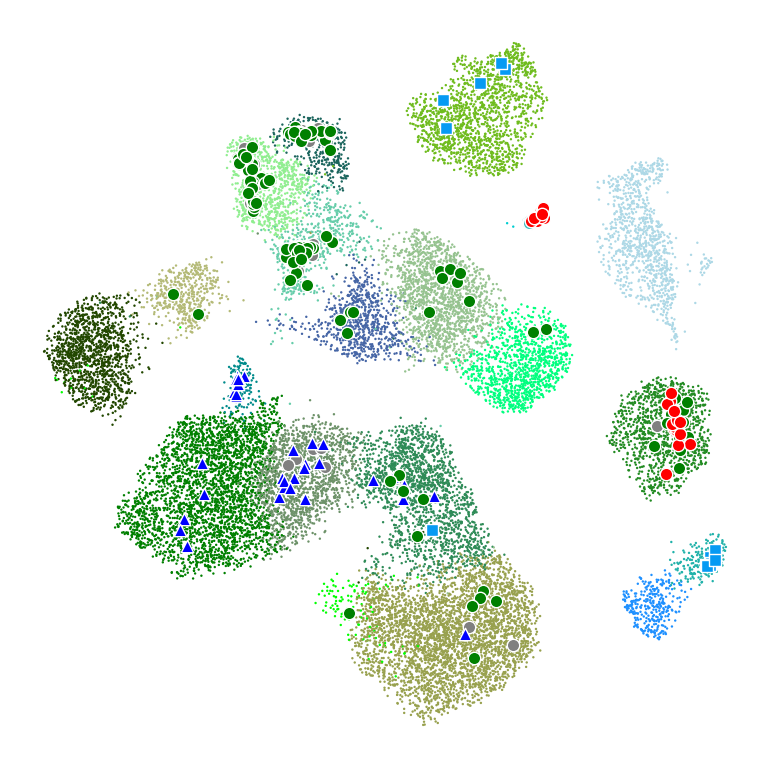

In [45]:
fig = plt.figure(figsize=(15,7.5))
ax1 = plt.axes([0,0,1/2,1])
# ax2 = plt.axes([1/2,0,1/2,1])

size=80
size2=80
# plot 10X data
plt.sca(ax1)
plt.scatter(Z0_umap[:,0], Z0_umap[:,1], s=3, alpha=1,
            c = clusterColors_Ext, edgecolor='none',
            rasterized=True)
# plot patchseq data (predicted inhibitory cells)
plt.scatter(pos_umap[patchCellSubtypeIDs_Ext==0,0], pos_umap[patchCellSubtypeIDs_Ext==0,1], s=size, alpha=1,
            c = 'grey', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs_Ext==1,0], pos_umap[patchCellSubtypeIDs_Ext==1,1], s=size, alpha=1,
            c = 'k', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs_Ext==2,0], pos_umap[patchCellSubtypeIDs_Ext==2,1], marker='^', s=size, alpha=1,
            c = 'b', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs_Ext==3,0], pos_umap[patchCellSubtypeIDs_Ext==3,1], s=size, alpha=1,
            c = 'g', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs_Ext==4,0]-0.2*np.random.rand(10), pos_umap[patchCellSubtypeIDs_Ext==4,1]-0.2*np.random.rand(10), s=size, alpha=1,
            c = '#3AB9BD', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs_Ext==5,0]+0.8*np.random.rand(14), pos_umap[patchCellSubtypeIDs_Ext==5,1]+0.8*np.random.rand(14), s=size2, alpha=1,
            c = 'r', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs_Ext==6,0], pos_umap[patchCellSubtypeIDs_Ext==6,1], s=size, alpha=1,
            c = 'r', edgecolor='w', rasterized=True)

plt.scatter(pos_umap[patchCellSubtypeIDs_Ext==8,0], pos_umap[patchCellSubtypeIDs_Ext==8,1], marker='s', s=size2, alpha=1,
            c = '#069AF3', edgecolor='w', rasterized=True)
# set figure properties
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('./figures/patchseq_2_Ext_10X-20250120.pdf',format='pdf',dpi=300)

In [46]:
pos_umap_Ext = pd.DataFrame(data=pos_umap,index=patchCellNames_Ext,columns=['UMAP1','UMAP2'])
pos_umap_Ext.insert(2,'predictClusterID',predictClusters_Ext.astype('int'))
pos_umap_Ext.insert(0,'patchCellSubtypeIDs',patchCellSubtypeIDs_Ext.astype('int'))
pos_umap_Ext.to_csv("./data/mappingRes/df_pos_umap_Ext.csv", mode="a" ,index = True, header=True)

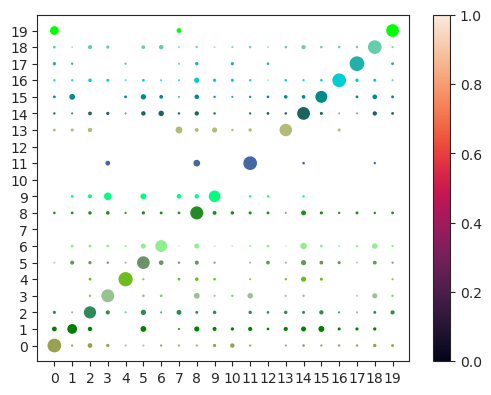

In [47]:
clusters = np.unique(predictClusters_Ext)
nCell = np.ones(20)*np.nan
meanCorrs = np.ones([20,20])*np.nan
for i in range(20):
    nCell[i] = np.sum(predictClusters_Ext==i)
    meanCorrs[i,:] = np.mean( Corrs_Ext[predictClusters_Ext==i,:],axis=0 )
    

x = np.transpose(range(20)*np.ones([20,20]))
y = np.ones([20,20])*range(20)
excColorTable = clusterColors_table[:20]

figsize(6,4.5)
plt.scatter(np.transpose(x),np.transpose(y),s=meanCorrs*100,c=excColorTable.repeat(20))
plt.xticks(range(20))
plt.yticks(range(20))

colorbar()
# plt.savefig('./figures/Corr_dotPlot_excMapiing.pdf',dpi=600)

### plot the violin plot of cell type groups by 10X scRNA clusters ###

In [48]:
ad_Ext

AnnData object with n_obs × n_vars = 21733 × 19944
    obs: 'batch', 'doublet_score', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster_labels', 'sampleLayers'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cluster_labels_colors', 'cluster_names', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sampleLayers_colors', 'tsne', 'umap'
    obsm: 'X_harmonypca', 'X_pca', 'X_tsne', 'X_umap', 'X_umapharmony', 'X_umapraw'
    varm: 'PCs'
    layers: 'RawCounts'
    obsp: 'connectivities', 'distances'

In [49]:
projNeuronTypeID_str = ad_Ext.obs['leiden'].astype('str')
projNeuronTypeName_str = projNeuronTypeID_str
projNeuronTypeID_str[ad_Ext.obs['leiden'].isin(['1','5','15'])] = '1'                       # L2/3  IT HPCAL1
projNeuronTypeName_str[ad_Ext.obs['leiden'].isin(['1','5','15'])] = 'L2/3 IT HPCAL1' 
projNeuronTypeID_str[ad_Ext.obs['leiden'].isin(['0','2','7','13','19'])] = '0'              # IT RORB
projNeuronTypeName_str[ad_Ext.obs['leiden'].isin(['0','2','7','13','19'])] = 'IT RORB'
projNeuronTypeID_str[ad_Ext.obs['leiden'].isin(['3','6','9','11','14','18'])] = '2'         # L5 IT FEZF2
projNeuronTypeName_str[ad_Ext.obs['leiden'].isin(['3','6','9','11','14','18'])] = 'L5 IT FEZF2'
projNeuronTypeID_str[ad_Ext.obs['leiden'].isin(['8'])] = '3'                                # L5/6 CT
projNeuronTypeName_str[ad_Ext.obs['leiden'].isin(['8'])] = 'L5/6 CT+' 
projNeuronTypeID_str[ad_Ext.obs['leiden'].isin(['4'])] = '4'                                # L6 IT 
projNeuronTypeName_str[ad_Ext.obs['leiden'].isin(['4'])] = 'L6 IT' 
projNeuronTypeID_str[ad_Ext.obs['leiden'].isin(['16'])] = '6'                               # L5 ET
projNeuronTypeName_str[ad_Ext.obs['leiden'].isin(['16'])] = 'L5 ET+'
projNeuronTypeID_str[ad_Ext.obs['leiden'].isin(['12','17'])] = '5'                          # L6b
projNeuronTypeName_str[ad_Ext.obs['leiden'].isin(['12','17'])] = 'L6b' 
projNeuronTypeID_str[ad_Ext.obs['leiden'].isin(['10'])] = '7'                               # Near-projecting PC
projNeuronTypeName_str[ad_Ext.obs['leiden'].isin(['10'])] = 'NP'  
ad_Ext.obs['projNeuronTypeID'] = projNeuronTypeID_str.astype('category')
ad_Ext.obs['projNeuronTypeName'] = projNeuronTypeName_str.astype('category')

In [50]:
# fingding marker genes
sc.tl.rank_genes_groups(ad_Ext, "projNeuronTypeID", method="t-test")

In [51]:
result = ad_Ext.uns["rank_genes_groups"]
groups = result["names"].dtype.names
geneTable = pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(60)

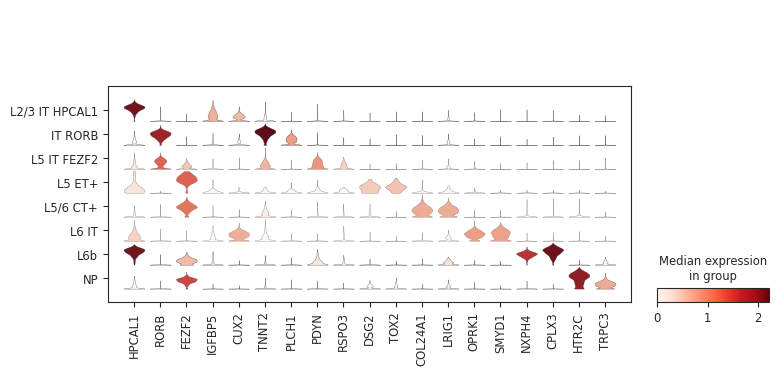

In [52]:
marker_genes = ['HPCAL1','RORB','FEZF2',
                'IGFBP5','CUX2',#'DGKA','SPON2','RASGRF2',
                'TNNT2','PLCH1',#'EIF4E1B','NGB','FBXO15',
                'PDYN','RSPO3',#'LHX2','NETO2','PLAC9',
                'DSG2','TOX2',#'PIK3R3','CACNA1H','HAPLN4','KCNN2','PTPRO',
                'COL24A1','LRIG1',#'ADRA1A','SULF1','TIAM1','KRT17',
                'OPRK1','SMYD1',#'RGS12','MYO1B','TSPAN18','NWD2','ZNF804A','NTNG2',
                'NXPH4','CPLX3',#'CDH24','NOV','CTGF','GSN',
                'HTR2C','TRPC3'#,'PCP4','SPON1','PKP3','SLC24A3'
                ]
categories_order = ['L2/3 IT HPCAL1','IT RORB','L5 IT FEZF2','L5 ET+','L5/6 CT+','L6 IT','L6b','NP']
sc.pl.stacked_violin(ad_Ext, marker_genes, groupby="projNeuronTypeName",categories_order=categories_order,cmap='Reds')#, swap_axes=True, save='projNeuronGroupCluster.pdf')

###### <font size=8> Mapping all VENs and layer 5/6 CTs to cluster 8 and cluster 16. 

In [53]:
cluster_8 = sc.read('../10X/data_h5/cluster8_20240405.h5ad')

In [54]:
# pick up the mapped VENs and L5/6CTs for re-mapping to UMAP of VENs & L5/6CTs, and more precise defien the cell types.
VEN_idx = ( (patchCellSubtypeIDs_Ext == 5) | (patchCellSubtypeIDs_Ext == 6) |(patchCellSubtypeIDs_Ext == 7) )
CT_VEN_idx = results_Ext['predictClustersIDs']==8 

In [55]:
patchCounts_CT_VEN = patchSeqCounts_Ext[CT_VEN_idx]
patchCellNames_CT_VEN = patchCellNames_Ext[CT_VEN_idx]
patchCellTypeIDs_CT_VEN = patchCellTypeIDs_Ext[CT_VEN_idx]
# patchCellTypes_CT_VEN = patchCellTypes_Ext[CT_VEN_idx]
patchCellSubtypeIDs_CT_VEN = patchCellSubtypeIDs_Ext[CT_VEN_idx]
patchCellSubtypes_CT_VEN = patchCellSubtypes_Ext[CT_VEN_idx]
patchMappingRates_CT_VEN = mappingRates_Ext[CT_VEN_idx]

In [56]:
# set the excluded genes (sex genes, mito genes) as not HVGs.
cluster_8.var['highly_variable'].values[cluster_8.var['highly_variable'].index.isin(excGenes)]=False

# extract and reformat data from AnnData (10X data)
counts_10X = cluster_8.layers['counts'][:,cluster_8.var['highly_variable']]
genes = cluster_8.var_names[cluster_8.var['highly_variable']]
cells = cluster_8.obs_names
clusterIDs = cluster_8.obs['leiden'].astype('int')

# extract the neurons positions in the embeded figures
Z0_umap = cluster_8.obsm['X_umap']

# assign the colors to neuron types.
subClusterColor_tables=np.array(['#B0C4DE', '#96C390', '#ADD8E6', '#1E90FF', '#B4BA77', '#20B2AA'])
clusterColors_CT_VEN = subClusterColor_tables[cluster_8.obs['leiden'].astype('int')]

In [57]:
# calculate the HVGs for mapping. 
importantGenesIndex = rnaseqTools.geneSelection(counts_10X, n=500, threshold=1, decay=4, plot=False)
counts_10X = counts_10X[:, importantGenesIndex] 
importantGenes = genes[importantGenesIndex]

Chosen offset: 1.61


### predict patch cells clusters...

In [58]:
predictClusters_CT_VEN, Corrs_CT_VEN = rnaseqTools.map_to_clusters(counts_10X, importantGenes,
                patchCounts_CT_VEN, patchSeqData.genes.astype('str'), clusterIDs, totalClusters=5,bootstrap = True)

Using a common set of 497 genes.
.................................................................................................... done


In [59]:
# output the original neuronal types and predicted labels into a dataframe for comparasion in convinient.
# predictClusterLabels = patchCellID
cellType_labels = patchSeqData.clusterIDs

maxCorrs_CT_VEN = np.max(Corrs_CT_VEN,axis=1)
d={#'patchCellNames': patchCellNames_CT_VEN, 
   'patchCellTypeIDs': patchCellTypeIDs_CT_VEN,
   # 'patchCellTypeNames': patchSeqData.clustergroupNames,
   'patchCellSubtypeIDs': patchCellSubtypeIDs_CT_VEN,
   'patchCellSubtypeNames': patchCellSubtypes_CT_VEN,
   'mappingRates': patchMappingRates_CT_VEN,
   'predictClustersIDs':predictClusters_CT_VEN.astype(int),
   'mainClusterCorrs': maxCorrs_CT_VEN }

results_CT_VEN = pd.DataFrame(data=d,index=patchCellNames_CT_VEN)

In [60]:
results_CT_VEN.to_csv("./data/mappingRes/results_CT_VEN.csv", mode="a" ,index = True, header=True)

In [61]:
predictClusters_CT_VEN

array([4., 4., 4., 4., 4., 4., 1., 1., 2., 1., 0., 4., 1., 4., 4., 4., 1.,
       3., 1., 4., 4., 1., 4., 1., 4., 4.])

In [62]:
pos_umap_CT_VENS = rnaseqTools.map_to_tsne1(counts_10X, importantGenes,
                patchCounts_CT_VEN, patchSeqData.genes.astype('str'), clusterIDs,  predictClusters_CT_VEN,
                Z0_umap, bootstrap = True, knn=10,seed=42)

Using a common set of 497 genes.
Bootstrapping.................................................................................................... done
(1, 2, 100)
Using a common set of 497 genes.
Bootstrapping.................................................................................................... done
(8, 2, 100)
Using a common set of 497 genes.
Bootstrapping.................................................................................................... done
(1, 2, 100)
Using a common set of 497 genes.
Bootstrapping.................................................................................................... done
(1, 2, 100)
Using a common set of 497 genes.
Bootstrapping.................................................................................................... done
(15, 2, 100)


In [63]:
pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==7,0].shape

(0,)

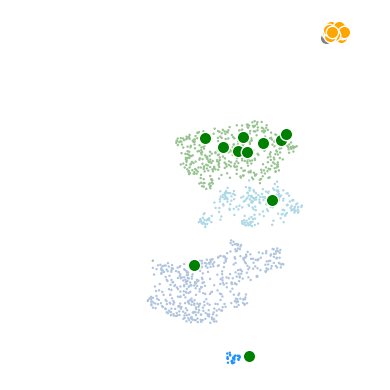

In [66]:
# plot 10X data
figsize(4,4)
size=80
size2=80
plt.scatter(Z0_umap[:,0], Z0_umap[:,1], s=3, alpha=1,
            c = clusterColors_CT_VEN, edgecolor='none',
            rasterized=True)
# plot patchseq data (predicted cluster 8 (L5/6CT+VENS) cells)
plt.scatter(pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==0,0], pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==0,1], s=size, alpha=1,
            c = 'grey', edgecolor='w', rasterized=True)
plt.scatter(pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==1,0], pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==1,1], s=size, alpha=1,
            c = 'k', edgecolor='w', rasterized=True)
plt.scatter(pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==2,0], pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==2,1], s=size, alpha=1,
            c = 'b', edgecolor='w', rasterized=True)
plt.scatter(pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==4,0], pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==4,1], s=size, alpha=1,
            c = '#3AB9BD', edgecolor='w', rasterized=True)
plt.scatter(pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==5,0], pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==5,1], s=size, alpha=1,    # VENL
            c = 'r', edgecolor='w', rasterized=True)
plt.scatter(pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==3,0]+1*np.random.rand(11), pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==3,1]+1*np.random.rand(11), s=size, alpha=1,      # VENS
            c = 'g', edgecolor='w', rasterized=True)
plt.scatter(pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==7,0], pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==7,1], s=size, alpha=1,   # un-certained VEN
            c = 'grey', edgecolor='w', rasterized=True)
plt.scatter(pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==6,0]+np.random.rand(14), pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==6,1]+np.random.rand(14), s=size, alpha=1,
            c = '#FFA500', edgecolor='w', rasterized=True)

plt.scatter(pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==8,0], pos_umap_CT_VENS[patchCellSubtypeIDs_CT_VEN==8,1], s=size2, alpha=1,
            c = '#069AF3', edgecolor='w', rasterized=True)
# set figure properties
plt.xticks([])
plt.yticks([])
plt.xlim([0,20])
sns.despine(left=True, bottom=True)
plt.tight_layout()

# plt.savefig('./figures/mapping2_CTandETcluster_new.pdf',dpi=600)

In [67]:
pos_umap_CT_VENS = pd.DataFrame(data=pos_umap_CT_VENS,index=patchCellNames_CT_VEN,columns=['UMAP1','UMAP2'])
pos_umap_CT_VENS.insert(2,'predictClusterID',predictClusters_CT_VEN.astype('int'))
pos_umap_CT_VENS.insert(0,'patchCellSubtypeIDs',patchCellSubtypeIDs_CT_VEN.astype('int'))
# pos_umap_CT_VENS.to_csv("./data/mappingRes/df_pos_umap_CT_VENS_20240415.csv", mode="a" ,index = True, header=True)

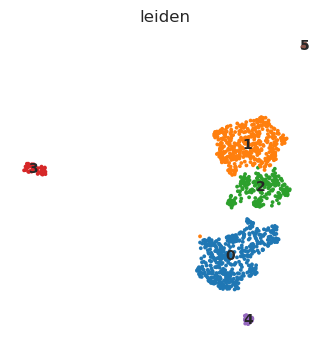

In [70]:
figsize(4,4)
cluster_8_16 = sc.read('../10X/data_h5/cluster_8_16.h5ad')
sc.pl.umap(cluster_8_16,color=['leiden'],legend_loc='on data', frameon=False, size=30)

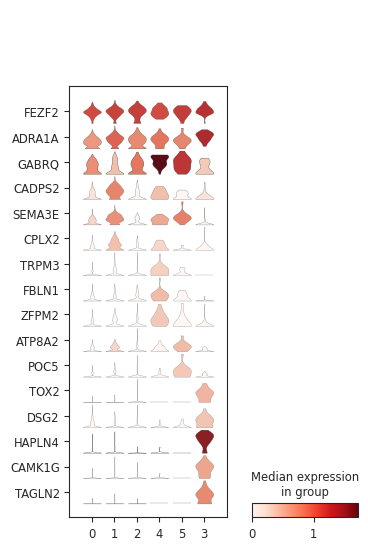

In [72]:
markers=['FEZF2','ADRA1A','GABRQ','CADPS2','SEMA3E','CPLX2','TRPM3','FBLN1','ZFPM2','ATP8A2','POC5','TOX2','DSG2','HAPLN4','CAMK1G','TAGLN2']
leiden_order = ['0','1','2','4','5','3']
sc.pl.stacked_violin(cluster_8_16, markers, groupby='leiden', categories_order=leiden_order, swap_axes = True,cmap='Reds', save='markers_cluster_8_16.pdf')
# sc.pl.dotplot(cluster_8_16, markers, groupby='leiden',swap_axes = True)

# <font size = 8> Mapping to all neurons atlas

In [73]:
ad_neurons = sc.read('../10X/data_h5/Neurons230826.h5ad')
ad_neurons

AnnData object with n_obs × n_vars = 38097 × 21684
    obs: 'batch', 'leiden', 'cluster_labels', 'doublet_score', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cluster_labels_colors', 'hvg', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_harmonypca', 'X_pca', 'X_umap', 'X_umapharmony', 'X_umapraw'
    varm: 'PCs'
    layers: 'RawCounts'
    obsp: 'connectivities', 'distances'

In [74]:
# assign the colors to neuron types.
clusterColors_AllNeurons = clusterColors_table[ad_neurons.obs['leiden'].astype('int')]

In [75]:
# re-read patchseq data
patchCellNames = patchSeqData.cellnames
patchCellTypeIDs = patchSeqData.clustergroupIDs
patchCellTypes = patchSeqData.clustergroupNames
patchCellSubtypeIDs= patchSeqData.clusterIDs
patchCellSubtypes= patchSeqData.clusterNames
mappingRates= patchSeqData.mappingrates

In [76]:
##### =============re-read 10X all neurons data============== 
# set the excluded genes (sex genes, mito genes) as not HVGs.
ad_neurons.var['highly_variable'].values[ad_neurons.var['highly_variable'].index.isin(excGenes)]=False

# extract and reformat data from AnnData (10X data)
counts_10X = ad_neurons.layers['RawCounts'].X[:,ad_neurons.var['highly_variable']]
genes = ad_neurons.var_names[ad_neurons.var['highly_variable']]
cells = ad_neurons.obs_names
clusterIDs = ad_neurons.obs['leiden'].astype('int')

# extract the neurons positions in the embeded figures
Z0_umap = ad_neurons.obsm['X_umap']


In [77]:
# calculate the HVGs for mapping. 
importantGenesIndex = rnaseqTools.geneSelection(counts_10X, n=500, threshold=1, decay=4, plot=False)
counts_10X = counts_10X[:, importantGenesIndex] 
importantGenes = genes[importantGenesIndex]

Chosen offset: 1.71


In [78]:
# Renew the predicted clusterIDs.
predictClusters = patchCellTypeIDs.copy()
predictClusters_inhib_new = predictClusters_inhib+20
predictClusters[patchCellNames.isin(patchCellNames_inhib)] = predictClusters_inhib_new
predictClusters[patchCellNames.isin(patchCellNames_Ext)] = predictClusters_Ext

maxCorrs = patchCellTypeIDs.copy()
maxCorrs[patchCellNames.isin(patchCellNames_inhib)] = maxCorrs_inhib
maxCorrs[patchCellNames.isin(patchCellNames_Ext)] = maxCorrs_Ext

In [79]:
d={'patchCellTypeIDs': patchCellTypeIDs,
   'patchCellSubtypeIDs': patchCellSubtypeIDs,
   'patchCellSubtypeNames': patchCellSubtypes,
   'mappingRates': mappingRates,
   'predictClustersIDs':predictClusters.astype(int),
   'mainClusterCorrs': maxCorrs }

results = pd.DataFrame(data=d,index=patchCellNames)

In [80]:
predictClusters = np.array(results['predictClustersIDs'])

In [81]:
pos_umap = rnaseqTools.map_to_tsne1(counts_10X, importantGenes,
                patchSeqData.counts, patchSeqData.genes.astype('str'), np.array(ad_neurons.obs['leiden'].astype('int')),  predictClusters,
                Z0_umap, bootstrap = True, knn=10,seed=42)

Using a common set of 497 genes.
Bootstrapping.................................................................................................... done
(8, 2, 100)
Using a common set of 497 genes.
Bootstrapping.................................................................................................... done
(5, 2, 100)
Using a common set of 497 genes.
Bootstrapping.................................................................................................... done
(12, 2, 100)
Using a common set of 497 genes.
Bootstrapping.................................................................................................... done
(7, 2, 100)
Using a common set of 497 genes.
Bootstrapping.................................................................................................... done
(5, 2, 100)
Using a common set of 497 genes.
Bootstrapping.................................................................................................... done
(18, 2, 100)
Using a common

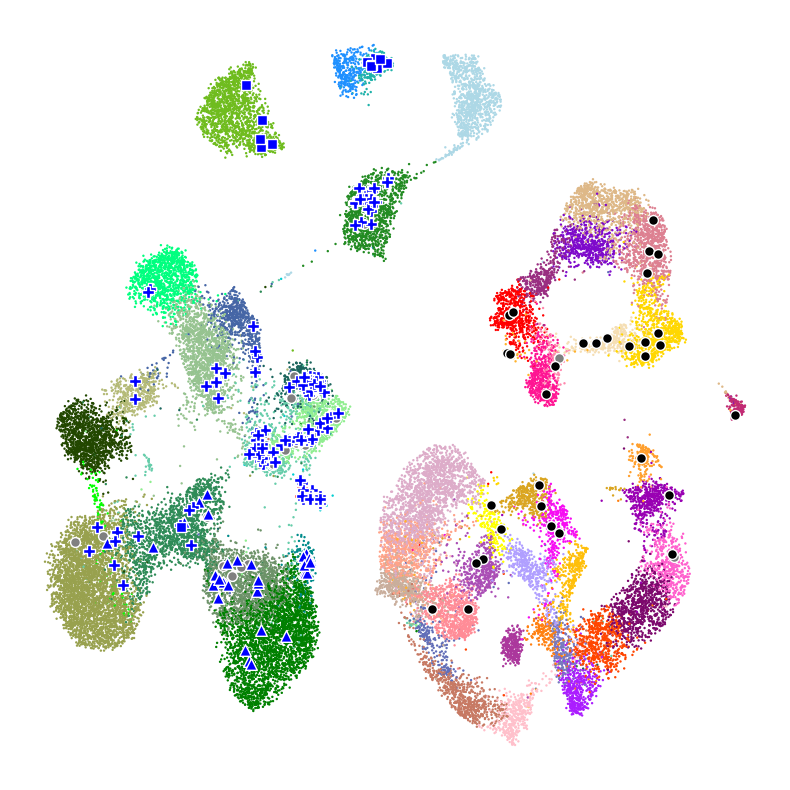

In [82]:
# plot 10X data
figsize(8,8)
plt.scatter(Z0_umap[:,0], Z0_umap[:,1], s=3, alpha=1,
            c = clusterColors_AllNeurons, edgecolor='none',
            rasterized=True)
# plot patchseq data (predicted inhibitory cells)
plt.scatter(pos_umap[patchCellSubtypeIDs==0,0], pos_umap[patchCellSubtypeIDs==0,1], s=50, alpha=1,
            c = 'grey', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs==1,0], pos_umap[patchCellSubtypeIDs==1,1], s=50, alpha=1,
            c = 'k', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs==2,0], pos_umap[patchCellSubtypeIDs==2,1], s=70, marker='^', alpha=1,
            c = 'b', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs==3,0], pos_umap[patchCellSubtypeIDs==3,1], s=70, marker='P', alpha=1,
            c = 'b', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs==4,0], pos_umap[patchCellSubtypeIDs==4,1], s=70, marker='P', alpha=1,
            c = 'r', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs==5,0], pos_umap[patchCellSubtypeIDs==5,1], s=70, marker='P', alpha=1,
            c = 'b', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs==6,0], pos_umap[patchCellSubtypeIDs==6,1], s=70, marker='P', alpha=1,
            c = 'b', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs==7,0], pos_umap[patchCellSubtypeIDs==7,1], s=50, marker='P', alpha=1,
            c = 'b', edgecolor='w', rasterized=True)
plt.scatter(pos_umap[patchCellSubtypeIDs==8,0], pos_umap[patchCellSubtypeIDs==8,1], s=50, marker='s', alpha=1,
            c = 'b', edgecolor='w', rasterized=True)
# set figure properties
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('./figures/patchSeq_2_Neurons_10X.pdf',dpi=600)

In [83]:
pos_umap_NeuronS = pd.DataFrame(data=pos_umap,index=patchCellNames,columns=['UMAP1','UMAP2'])
pos_umap_NeuronS.insert(2,'predictClusterID',predictClusters.astype('int'))
pos_umap_NeuronS.insert(0,'patchCellSubtypeIDs',patchCellSubtypeIDs.astype('int'))
# pos_umap_NeuronS.to_csv("./data/mappingRes/df_pos_umap_neurons_20240415.csv", mode="a" ,index = True, header=True)

In [84]:
predictClusters_neurons, Corrs_neurons = rnaseqTools.map_to_clusters(counts_10X, importantGenes,
                patchSeqData.counts, patchSeqData.genes.astype('str'), clusterIDs, totalClusters=53,bootstrap = True)

nCell = np.ones(53)*np.nan
meanCorrs = np.ones([53,53])*np.nan
for i in range(53):
    nCell[i] = np.sum(predictClusters_neurons==i)
    meanCorrs[i,:] = np.mean( Corrs_neurons[predictClusters_neurons==i,:],axis=0 )
    

x = np.transpose(range(53)*np.ones([53,53]))
y = np.ones([53,53])*range(53)

Using a common set of 497 genes.
.................................................................................................... done


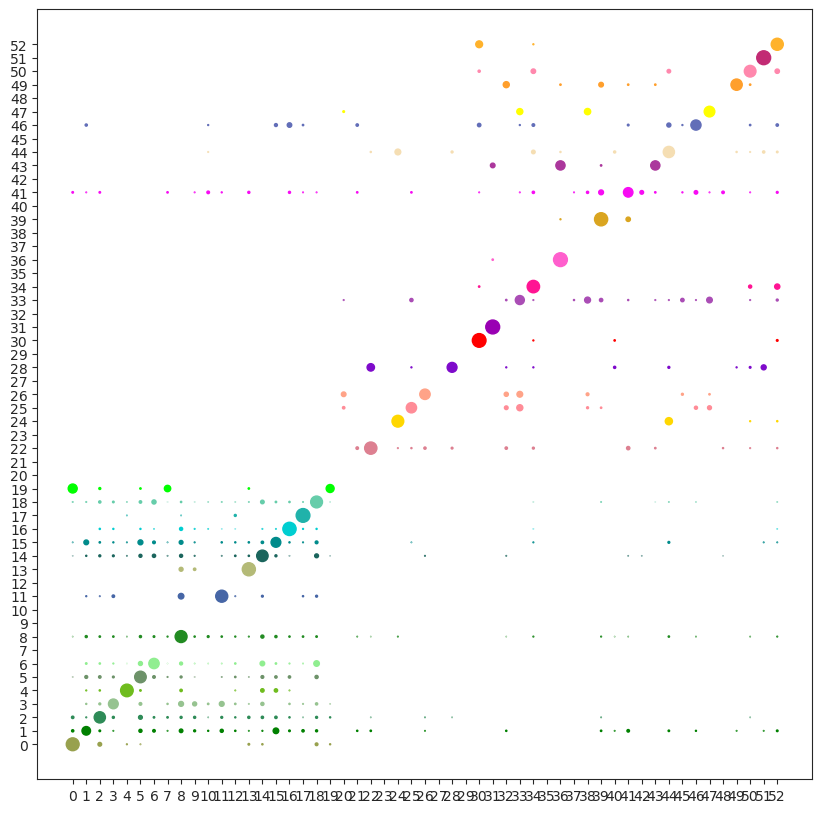

In [86]:
figsize(10,10)
plt.scatter(np.transpose(x),np.transpose(y),s=meanCorrs*100,c=clusterColors_table.repeat(53))
plt.xticks(range(53))
plt.yticks(range(53))

plt.savefig('./figures/Corr_dotPlot_neuronsMapiing.pdf',dpi=600)

In [87]:
ad_neurons

AnnData object with n_obs × n_vars = 38097 × 21684
    obs: 'batch', 'leiden', 'cluster_labels', 'doublet_score', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cluster_labels_colors', 'hvg', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_harmonypca', 'X_pca', 'X_umap', 'X_umapharmony', 'X_umapraw'
    varm: 'PCs'
    layers: 'RawCounts'
    obsp: 'connectivities', 'distances'